In [1]:
include("harvey.jl")
using .julia


using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions


using NLopt

using Plots
using StatsPlots  
using DataFrames
using XLSX

## Load data

In [2]:

file_path = "quarterly_gdp.xlsx"
sheet_name = "Quarterly GDP"

data = XLSX.readtable(file_path, sheet_name) |> DataFrame

println(data)

num_obs = size(data, 1)
println("Number of observations: ", num_obs)


134×2 DataFrame
 Row │ Date    Value 
     │ Any     Any   
─────┼───────────────
   1 │ 1991K1  364.6
   2 │ 1991K2  364.7
   3 │ 1991K3  368.6
   4 │ 1991K4  364.5
   5 │ 1992K1  371.5
   6 │ 1992K2  367.9
   7 │ 1992K3  377.2
   8 │ 1992K4  375.4
   9 │ 1993K1  371.8
  10 │ 1993K2  370
  11 │ 1993K3  373.2
  12 │ 1993K4  375.7
  13 │ 1994K1  385.1
  14 │ 1994K2  391.5
  15 │ 1994K3  393.3
  16 │ 1994K4  399.8
  17 │ 1995K1  404.2
  18 │ 1995K2  402.5
  19 │ 1995K3  404
  20 │ 1995K4  406.7
  21 │ 1996K1  407.8
  22 │ 1996K2  418.3
  23 │ 1996K3  419
  24 │ 1996K4  419.1
  25 │ 1997K1  424.8
  26 │ 1997K2  431.6
  27 │ 1997K3  429.7
  28 │ 1997K4  430.9
  29 │ 1998K1  437.5
  30 │ 1998K2  434
  31 │ 1998K3  441.2
  32 │ 1998K4  444.1
  33 │ 1999K1  447.8
  34 │ 1999K2  449.8
  35 │ 1999K3  451.7
  36 │ 1999K4  459.7
  37 │ 2000K1  462.9
  38 │ 2000K2  468.1
  39 │ 2000K3  468.9
  40 │ 2000K4  476.5
  41 │ 2001K1  469.1
  42 │ 2001K2  472.2
  43 │ 2001K3  475.3
  44 │ 2001K4  477.7
  

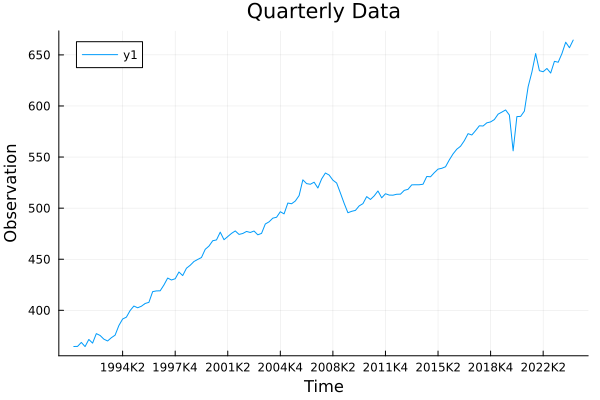

In [3]:
y = data[:, 2]
# y = log.(y)
dates = data[:, 1]

# Plot the data
plot(dates,y, title="Quarterly Data", xlabel="Time", ylabel="Observation")

In [4]:
#Define model
n_order = 2
state_dim = 2 + 2 * n_order
alpha_init = zeros(state_dim)
alpha_init[1] = y[1]
P1 = Matrix{Float64}(I(state_dim))  # Initial covariance matrix

#Priors
a_rho = 0.001
b_rho = 0.97
a_lambda = 0.001
b_lambda = π
a_xi = 1e-6
b_xi =1e-6
a_kappa = 1e-6
b_kappa = 1e-6
a_epsilon = 1e-6  
b_epsilon = 1e-6
priors = [a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa, b_kappa, a_epsilon, b_epsilon]




10-element Vector{Float64}:
 0.001
 0.97
 0.001
 3.141592653589793
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6

In [5]:
# Run MCMC initialization
chain_init_burned, Sigma, acceptance_rate_init, chain_init = initialize_mcmc(
    y,
    priors,
    alpha_init, 
    P1, 
    n_order; 
    n_init=40000, 
    burn_init=20000, 
    omega_init=0.08)


Initialization Phase 100%|███████████████████████████████| Time: 0:00:18m


Initialization Acceptance Rate: 28.7775 %


([0.6626595799040951 -1.9534646437714627 … 1.8259131555509702 2.4294005999931865; 0.6626595799040951 -1.9534646437714627 … 1.8259131555509702 2.4294005999931865; … ; 1.3490798254638467 -1.7596022328067027 … 0.7448160152851202 2.7987851994504593; 1.3490798254638467 -1.7596022328067027 … 0.7448160152851202 2.7987851994504593], [0.18200542573907758 0.0038580975977423044 … -0.20242300811351596 0.05708662459157645; 0.0038580975977423044 1.0713863412996938 … -0.45903997211822767 0.05097093421770349; … ; -0.20242300811351596 -0.45903997211822767 … 0.5871708799359663 -0.10047601127751882; 0.05708662459157645 0.05097093421770349 … -0.10047601127751882 0.06819016695613407], 0.287775, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.3490798254638467 -1.7596022328067027 … 0.7448160152851202 2.7987851994504593; 1.3490798254638467 -1.7596022328067027 … 0.7448160152851202 2.7987851994504593])

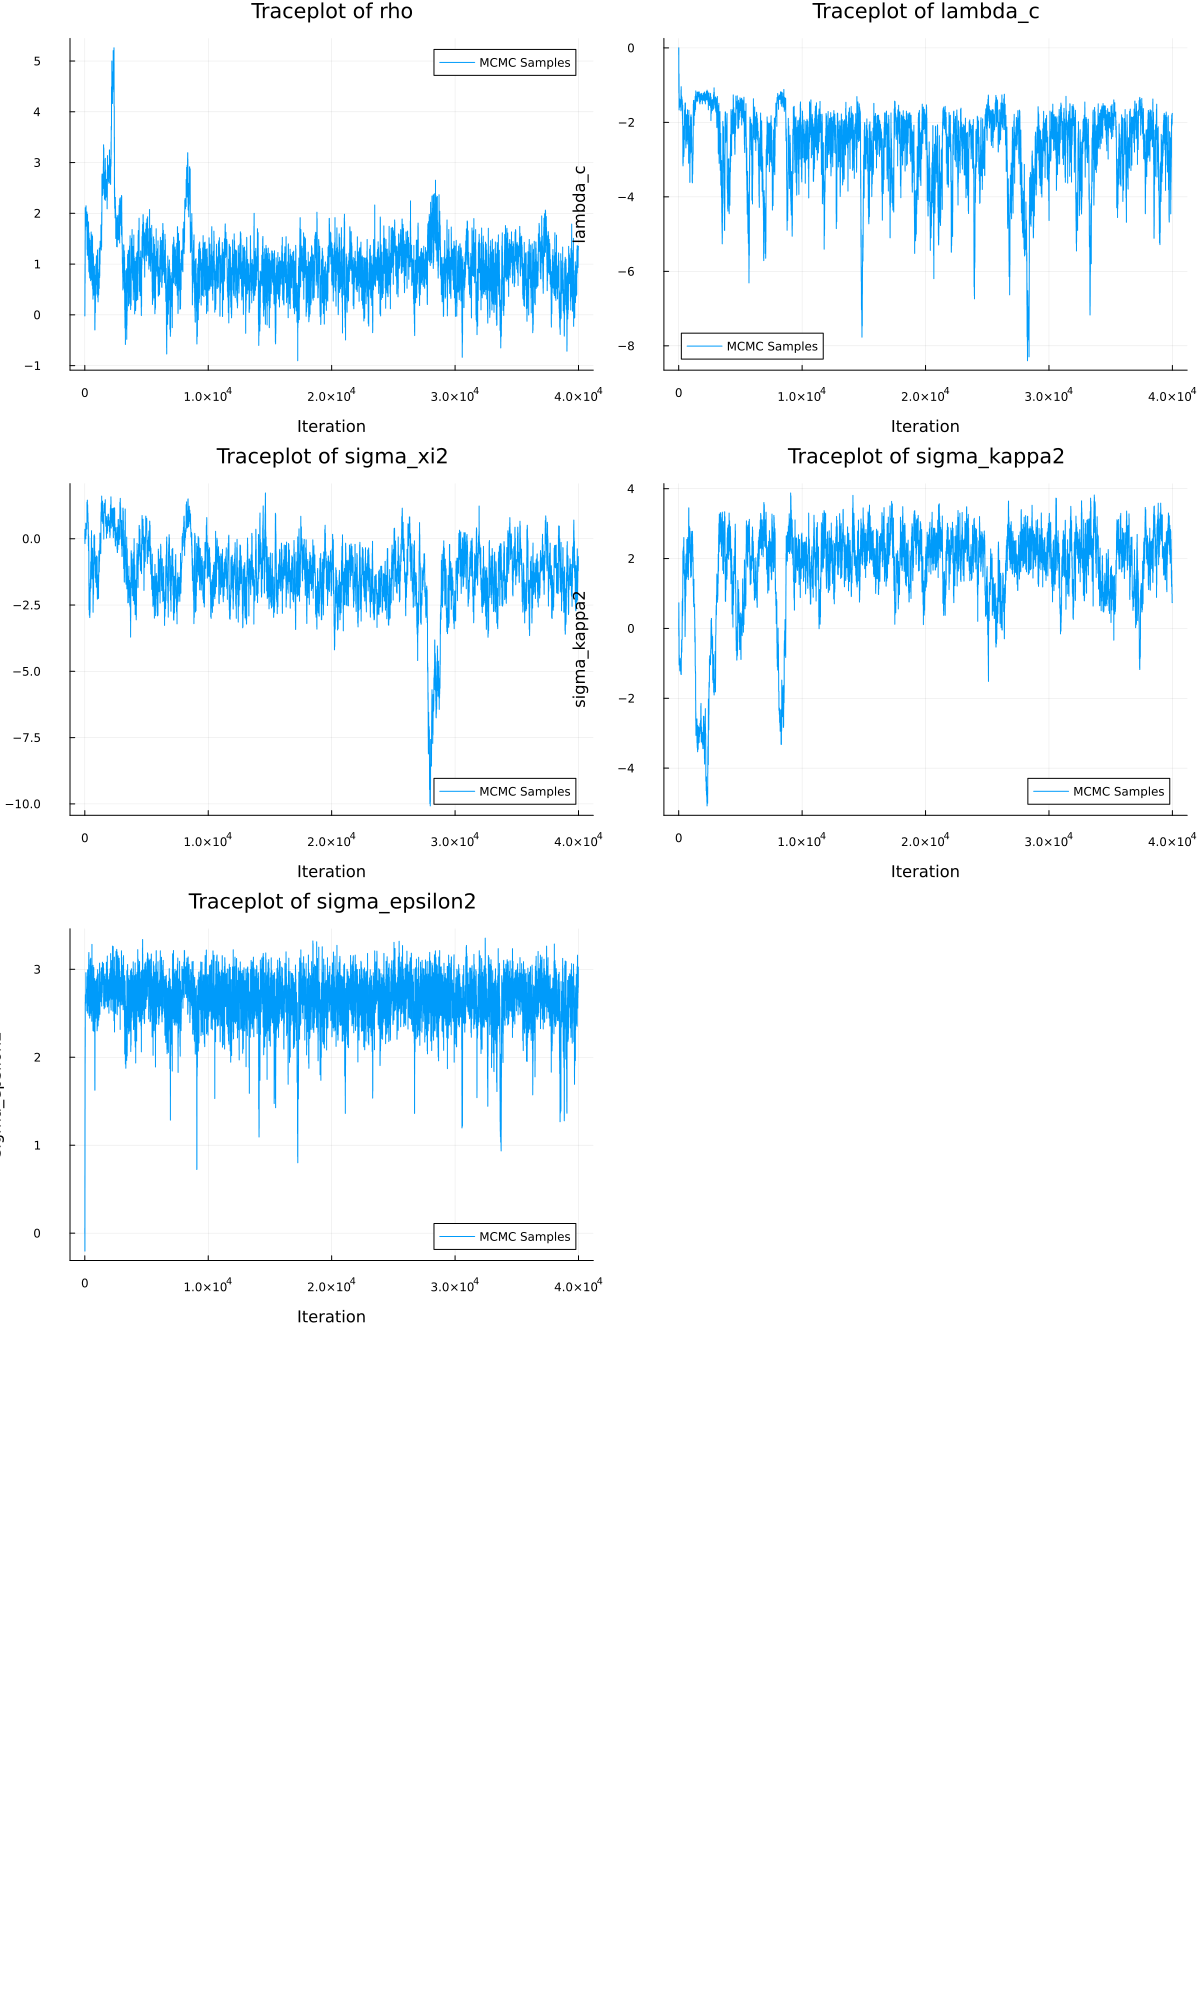

In [6]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)


# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples_init = chain_init[:, i]
    
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples_init, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")

    
    # Add plots to the list
    push!(p_list, p2)
end

# Display the plots
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [7]:
# Run MCMC recursion
theta_samples_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, 
    priors,
    alpha_init, 
    P1, 
    n_order, 
    chain_init_burned, 
    Sigma; 
    n_rec=40000, 
    burn_rec=20000, 
    omega_rec=0.25)


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:44m


Recursion Acceptance Rate: 40.8925 %


([0.7690533309589013 0.3240390669881611 … 3.6861330086727206 15.436296630395727; 0.7690533309589013 0.3240390669881611 … 3.6861330086727206 15.436296630395727; … ; 0.7018321657284233 0.3152662946776143 … 4.293306995576748 23.785259990953918; 0.7417270843115529 0.33066341249726955 … 3.071516168647889 28.44842471388567], Any[[364.08373713560616 1.580020141612434 … -0.5614923926211323 0.3416811251127516; 365.66375727721856 1.2960557841341194 … -0.5895882376280664 1.183716104249854; … ; 648.85865489513 2.720148705977887 … 11.41306101266351 9.580916393139903; 651.5788036011079 3.504642829465616 … 13.86252520857996 8.253612586240816], [365.76376648839897 0.7205509458416282 … 0.628528891969521 -0.982867069406477; 366.4843174342406 0.8343735579641529 … -0.14545355194651177 -0.9340610779143539; … ; 653.0432984434872 2.978604580438806 … 8.631310323111132 -0.3166848114280425; 656.021903023926 2.9305218429834383 … 8.993432231037783 -7.213744135617362], [363.0956486965397 1.5598469018307726 … 0.430

In [8]:

# Initial guesses for parameters
initial_params = [0.5, 0.2, 0.5, 0.5, 0.5]

# Bounds for parameters
lower_bounds = [0.0, 0.0, 1e-6, 1e-6, 1e-6]
upper_bounds = [0.999, π, Inf, Inf, Inf]


# Define the objective function
function obj(params::Vector, grad::Vector)
    try
        return negative_log_likelihood(params, y, alpha_init, P1, n_order)
    catch e
        return 1e10  # Return a large number in case of error
    end
end

# Create the optimizer
opt = Opt(:LN_NELDERMEAD, length(initial_params))
opt.lower_bounds = lower_bounds
opt.upper_bounds = upper_bounds
opt.min_objective = obj
opt.maxeval = 1000
opt.xtol_rel = 1e-6

# Run the optimization
(minf, estimated_params, ret) = NLopt.optimize(opt, initial_params)

# Display the estimated parameters
println("Estimated Parameters: ", estimated_params)


Estimated Parameters: [0.0, 3.141592653589793, 7.760460047468539, 17.500595336676497, 1.0e-6]


In [9]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)




5

In [10]:
# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples = theta_samples_burned[:, i]
    
    # Histogram of posterior samples
    p1 = histogram(param_samples, bins=50, normalize=true, alpha=0.6,
                   label="Posterior", xlabel=parameters[i], ylabel="Density",
                   title="Posterior Histogram and Prior of $(parameters[i])")
    
    # Define the prior distribution
    if parameters[i] == "rho"
        # Uniform prior between 0 and 0.999
        x_values = range(a_rho, b_rho, length=200)
        prior_pdf = pdf.(Uniform(a_rho, b_rho), x_values)
    elseif parameters[i] == "lambda_c"
        # beta distribution
        x_values = range(a_lambda, b_lambda, length=200)
        prior_pdf = pdf.(Uniform(a_lambda, b_lambda), x_values)
    elseif parameters[i] == "sigma_xi2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_xi, b_xi), x_values)
    elseif parameters[i] == "sigma_kappa2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_kappa, b_kappa), x_values)
    elseif parameters[i] == "sigma_epsilon2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_epsilon, b_epsilon), x_values)
    end
    
    # Overlay prior PDF on histogram
    plot!(p1, x_values, prior_pdf, label="Prior", color=:red, linewidth=2)
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")

    
    # Add plots to the list
    push!(p_list, p1)
    push!(p_list, p2)
end

# Display the plots 
nrows = n_params
ncols = 2
recursion_plot = plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))
savefig(recursion_plot, "harvey_estimation.png")




"c:\\Users\\marti\\OneDrive - University of Copenhagen\\Økonomi\\9. semester\\Empirical macro\\State-Space-Model-Estimation-1\\Harvey\\harvey_estimation.png"

In [11]:
# Calculate means of posterior samples
chain_rec_burned_means = mean(theta_samples_burned, dims=1)  # 1 x n_params array
chain_rec_burned_means = vec(chain_rec_burned_means)  # Convert to a vector


5-element Vector{Float64}:
  0.6860905155305581
  0.2542695402634219
  0.37140172580732156
  8.654690005633288
 14.842883192160178

In [12]:

# Create the DataFrame
estimates_table = DataFrame(Dict(
    "Parameter" => parameters,
    "MCMC Estimate" => chain_rec_burned_means,
    # "MLE Estimate" => estimated_params,  # Include if available
    # "True Value" => params_true
))

# Display the DataFrame
display(estimates_table)


5×2 DataFrame
 Row │ MCMC Estimate  Parameter      
     │ Float64        String         
─────┼───────────────────────────────
   1 │      0.686091  rho
   2 │      0.25427   lambda_c
   3 │      0.371402  sigma_xi2
   4 │      8.65469   sigma_kappa2
   5 │     14.8429    sigma_epsilon2

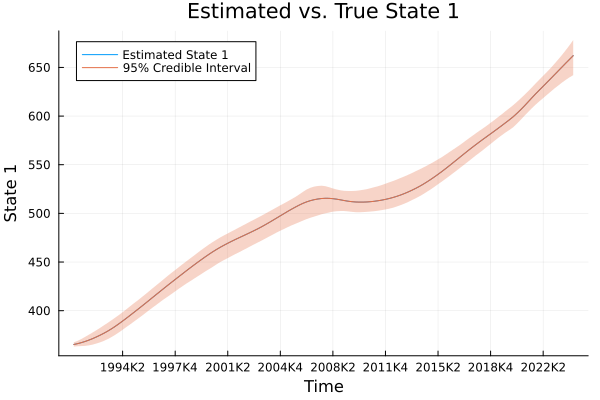

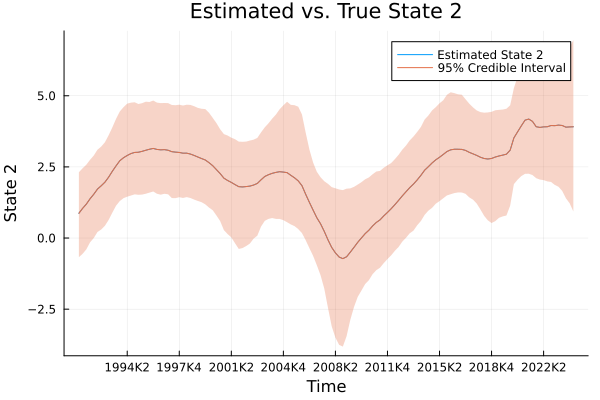

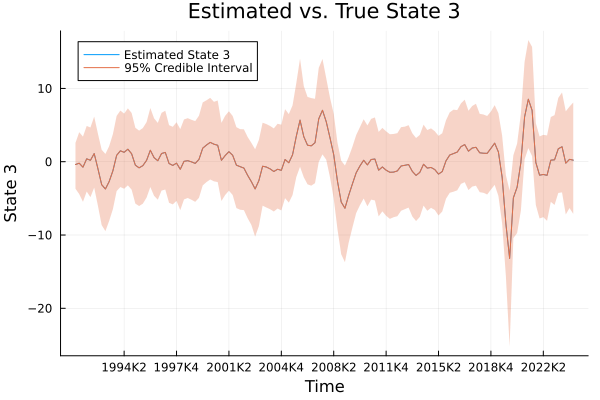

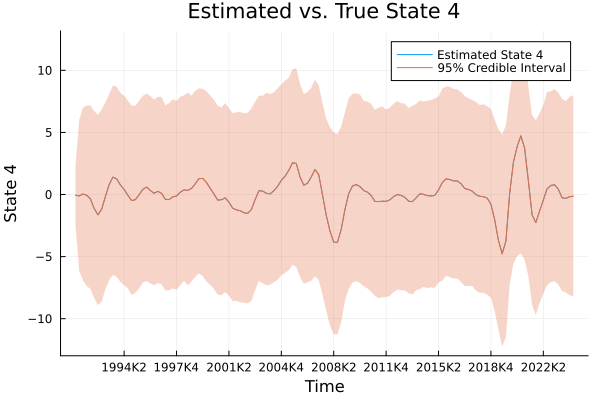

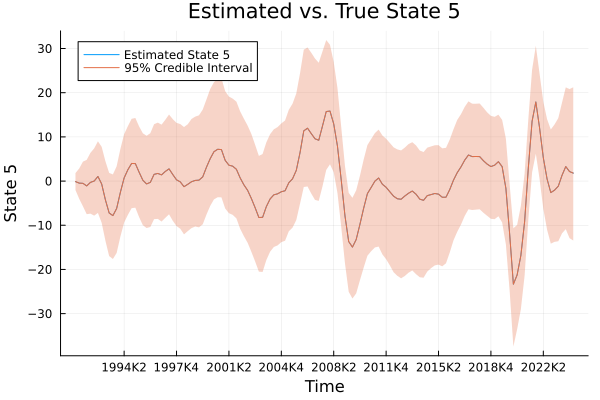

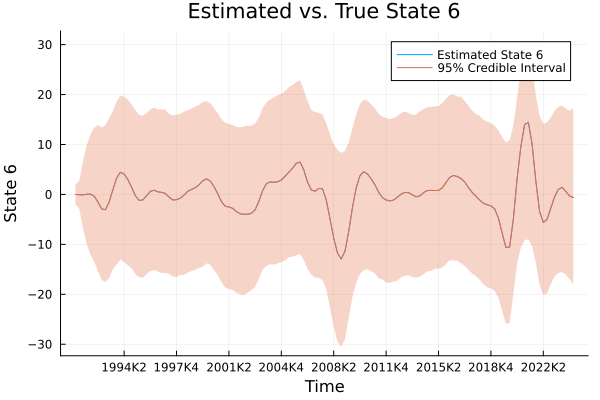

In [13]:
# Collect alpha samples into a 3D array
n_samples = length(alpha_samples)
n_time_steps = size(alpha_samples[1], 1)
state_dim = size(alpha_samples[1], 2)

dates_plot = dates


# Initialize array to hold alpha samples
alpha_samples_array = Array{Float64}(undef, n_samples, n_time_steps, state_dim)

for i in 1:n_samples
    alpha_samples_array[i, :, :] = alpha_samples[i]
end


# Compute posterior mean over samples (dimension 1)
alpha_mean = mean(alpha_samples_array, dims=1)  # 1 x n_time_steps x state_dim
alpha_mean = dropdims(alpha_mean; dims=1)  # n_time_steps x state_dim

# Compute credible intervals
alpha_lower = mapslices(x -> quantile(x, 0.025), alpha_samples_array; dims=1)
alpha_lower = dropdims(alpha_lower; dims=1)
alpha_upper = mapslices(x -> quantile(x, 0.975), alpha_samples_array; dims=1)
alpha_upper = dropdims(alpha_upper; dims=1)



time = 1:n_time_steps

for s in 1:state_dim
    p = plot(dates_plot, alpha_mean[:, s], label="Estimated State $(s)", xlabel="Time",
             ylabel="State $(s)", title="Estimated vs. True State $(s)")
    
    # Add credible intervals
    plot!(dates_plot, alpha_mean[:, s], ribbon=(alpha_mean[:, s] .- alpha_lower[:, s],
          alpha_upper[:, s] .- alpha_mean[:, s]), fillalpha=0.3, label="95% Credible Interval")
  
    display(p)
end


In [17]:
using JLD2

# Save the states to a JLD2 file
@save "states_harvey.jld2" alpha_mean alpha_lower alpha_upper



(134,)
(134,)


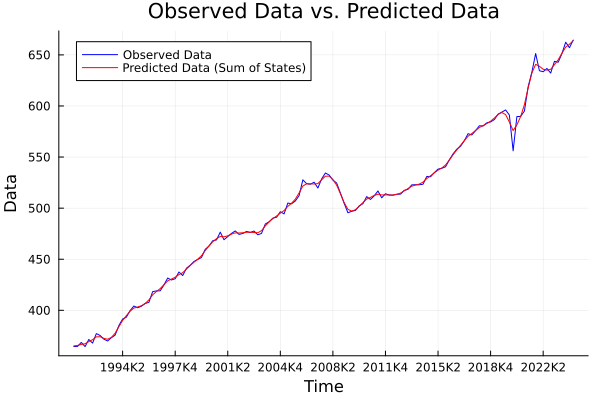

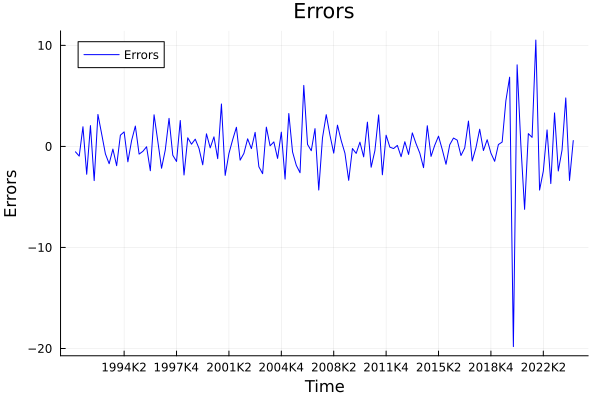

In [15]:
# Compute y_pred

state_indices = [1, 2+2*n_order-1] 

y_pred = alpha_mean[:, state_indices[1]] .+ alpha_mean[:, state_indices[2]]


# Adjust time and observed data if necessary
y_adjusted = y

println(size(y))
println(size(y_pred))

p = plot(dates_plot, y_adjusted, label="Observed Data", color=:blue)
plot!(p, dates_plot, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Data")
display(p)


errors = y_adjusted .- y_pred

p_error = plot(dates_plot, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)


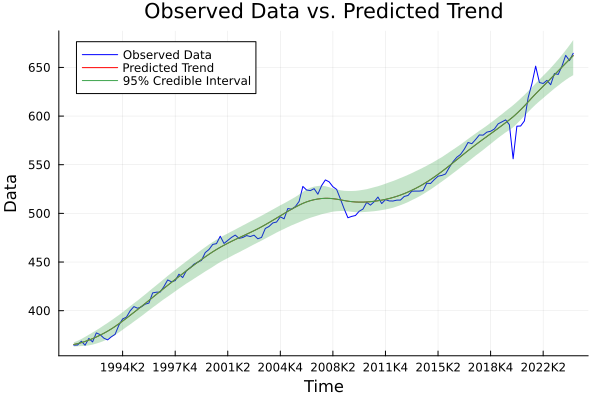

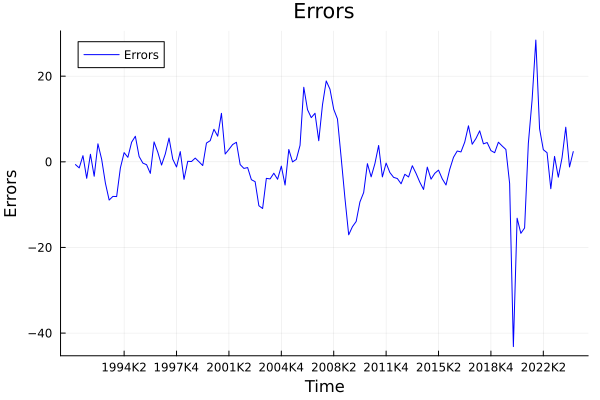

In [16]:




state_indices = [1, 2+2*n_order-1]  

y_pred = alpha_mean[:, state_indices[1]] 


# Adjust time and observed data if necessary
y_adjusted = y

p = plot(dates_plot, y_adjusted, label="Observed Data", color=:blue)
plot!(p, dates_plot, y_pred, label="Predicted Trend", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Trend")

# Add credible intervals using the `ribbon` argument
plot!(dates_plot, y_pred, ribbon=(alpha_mean[:, state_indices[1]] .- alpha_lower[:, state_indices[1]],
      alpha_upper[:, state_indices[1]] .- alpha_mean[:, state_indices[1]]), fillalpha=0.3, label="95% Credible Interval")

display(p)


errors = y_adjusted .- y_pred


p_error = plot(dates_plot, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)
